In [1]:
#Imports
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy 
import netCDF4
from shapely.geometry import Point, LineString, MultiPoint
from scipy.interpolate import griddata
import scipy.interpolate
import cmocean
from sklearn import datasets, preprocessing
from eofs.standard import Eof                              #EOFs!!
import seaborn as sns

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/')
#Import custom functions
from read_CTD import read_CTD    #To read CTD files
from out_outliers import out_outliers     #To replace outliers
import plotting_functions as plot   #To plot vertical profiles, T-S and vertical sections
from maps import mapa, map_layers    #To plot maps
from stations import stations
from transsects import select_transsects
from dict_units import dict_units

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/distance')
from distances import *

In [2]:
#Data reading and outlier replacement
data_dirs = ['C:/Users/pauab/Universidad/Data/TFM/CTD_recalc/']
data=read_CTD(data_dirs)

for ncast in data.keys():
    for variable in data[ncast].columns:
        out_outliers(data, ncast, variable)
    data[ncast]['pressure'] = data[ncast].index
    data[ncast].index = np.arange(0, len(data[ncast].index))

#Dict with all transsects
all_transsects = {'transsect_0':['15','12','13','14'],
                  'transsect_1':['19','18','17','16'],
                  'transsect_2':['24','23','22','21'],
                  'transsect_3':['26','27','28','29'],
                  'transsect_4':['31','32','33','34'],
                  'transsect_5':['38','37','36','35'],
                  'transsect_6':['43','44','45','46']}

#Dict with the stations grouped according to its position
all_stations_grouped = {}
for i in range(len(list(all_transsects.values())[0])):
    key = 'stations_'+str(i+1)
    all_stations_grouped[key]=[]
    for transsect in all_transsects.values():
        all_stations_grouped[key].append(transsect[i])

C:\Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions\read_CTD.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i].rename(columns=name_columns, inplace=True)


In [3]:
#Import a dictionary with the units of the variables
variables = list(data['09'].keys())
units = dict_units(variables)

In [4]:
#Select the transsects of interest
transsects_selected = [1,2,3,4,5,6]
transsects_ncast, stations_grouped = select_transsects(all_transsects, transsects_selected)

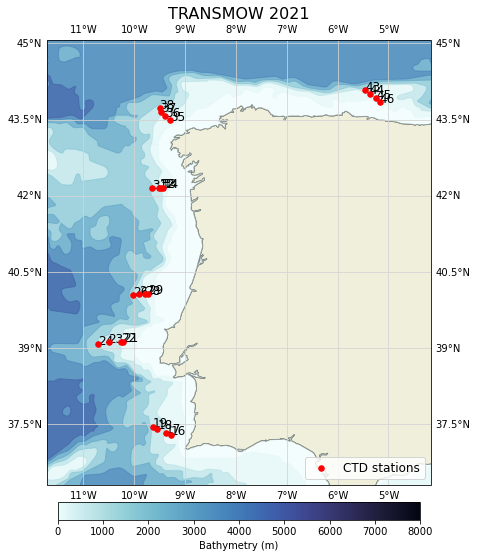

In [5]:
#Map the transsects
ncasts = np.array(list(transsects_ncast.values())).reshape(len(transsects_ncast)*len(stations_grouped))
mapa(data, ncasts, labels=True, xoffset=1, yoffset=1)

In [6]:
#Extract the reference depth for each station
#We will cut the CTD datasets according to the reference depth for each station
ref_deps={} 
for i in range(len(stations_grouped)):   #iterate over number of transsect stations
    dep_trans=[]
    for ncasts in transsects_ncast.values():
        dep=len(data[ncasts[i]].index)
        dep_trans.append(dep)
    key=str('station_'+str(i+1))
    ref_deps[key]=min(dep_trans)
print(ref_deps)

list_refdeps = list(ref_deps.values())

{'station_1': 1789, 'station_2': 1374, 'station_3': 969, 'station_4': 454}


In [7]:
#Limiting the CTD datasets to the reference depths established
i = 0
for ncasts in stations_grouped.values():
    for ncast in ncasts:
        data[ncast]=data[ncast].iloc[0:list_refdeps[i]]
    i+=1

In [27]:
variable = 'oxygen'

mean_profiles = {}
std_profiles = {}
for i in range(len(stations_grouped)):
    group = list(stations_grouped.values())[i]
    group_var = []
    for ncast in group:
        var = data[ncast][variable].values
        group_var.append(var)
    group_var = np.array(group_var)
    mean_profile = group_var.mean(axis=0)
    std_profile = group_var.std(axis=0)
    key = 'stations_'+str(i+1)
    mean_profiles[key] = mean_profile
    std_profiles[key] = std_profile

In [28]:
#Create a concatenate DataFrame of the EOFs matrix stored in a dict to ease the plotting

n_stat = len(stations_grouped)
#We established that the stations are all equally separated to ease the plotting work (which it is not true)
dist = np.linspace(0,1,n_stat)

data_conc_mean = pd.DataFrame(dtype='float64')
for mean_profile in mean_profiles.values():
    if data_conc_mean.empty:
        data_conc_mean = pd.Series(mean_profile)
    else:
        data_conc_mean = pd.concat([data_conc_mean, pd.Series(mean_profile)])

In [29]:
#Create a concatenate DataFrame of the EOFs matrix stored in a dict to ease the plotting

n_stat = len(stations_grouped)

#We established that the stations are all equally separated to ease the plotting work (which it is not true)
dist = np.linspace(0,1,n_stat)

data_plot = {}
data_plot['mean_profile'] = pd.DataFrame(dtype='float64')
data_plot['std_profile'] = {}

data_conc_mean = pd.DataFrame(dtype='float64')
data_conc_std = pd.DataFrame(dtype='float64')

keys_mean = list(mean_profiles.keys())
keys_std = list(std_profiles.keys())

for a in range(n_stat):
    dic_mean = {variable:mean_profiles[keys_mean[a]], 'x':dist[a], 'depth':np.linspace(0,list_refdeps[a]-1, list_refdeps[a])}
    df_mean = pd.DataFrame(dic_mean)
    if data_conc_mean.empty:
        data_conc_mean = df_mean
    else:
        data_conc_mean = pd.concat([data_conc_mean, df_mean])
        
    dic_std = {variable:std_profiles[keys_std[a]], 'x':dist[a], 'depth':np.linspace(0,list_refdeps[a]-1, list_refdeps[a])}
    df_std = pd.DataFrame(dic_std)
    if data_conc_std.empty:
        data_conc_std = df_std
    else:
        data_conc_std = pd.concat([data_conc_std, df_std])

data_plot['mean_profile'] = data_conc_mean
data_plot['std_profile'] = data_conc_std

# Plotting MEAN transsect and STD transsect

In [30]:
#Path to export the figures
path = 'C:/Users/pauab/Universidad/TFM/Figuras/std_mean/'

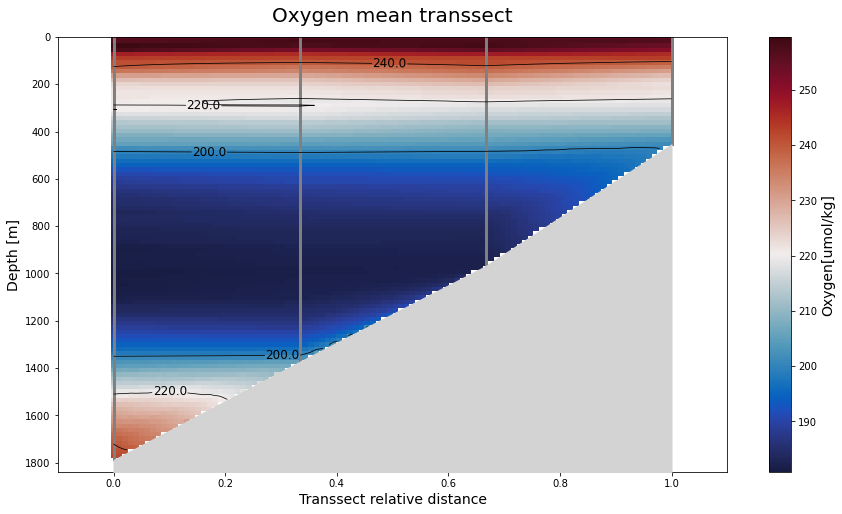

In [31]:
cmap = cmocean.cm.balance
interpolation = 'linear'

fig, ax1 = plt.subplots(1,1,figsize=(15,8))

#2nd plot
ax1.set_xlim(-0.1,1.1)
ax1.set_ylim(max(list_refdeps)+50,0)

#Creating the grid
points = list(zip(data_plot['mean_profile']['x'], data_plot['mean_profile']['depth']))
xi, yi = np.mgrid[0:1:100j, 0:max(list_refdeps):100j]
grid_ztest = griddata(points, data_plot['mean_profile'][variable], (xi, yi), method=interpolation, rescale=True)
#grid_ztest = np.nan_to_num(grid_ztest)

handle2 = ax1.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto')
b = ax1.scatter(data_plot['mean_profile']['x'], data_plot['mean_profile']['depth'], c='grey', s=2)

levels = 3
CS = ax1.contour(xi, yi, grid_ztest, levels=levels, colors=['k'], linewidths=0.75)
ax1.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=12)

cb = plt.colorbar(handle2, ax=ax1)
ax1.fill_between(dist,list_refdeps,max(list_refdeps)+100, color='lightgray', zorder=100)
ax1.margins(0.05)

plt.yticks(np.arange(0,2000,200))

cb.set_label(variable[0].upper()+variable[1:]+units[variable], fontsize = 14)
plt.ylabel('Depth [m]', fontsize = 14)
plt.xlabel('Transsect relative distance', fontsize = 14)
plt.title(variable[0].upper()+variable[1:]+' mean transsect',fontsize=20, pad=15)

#plt.savefig(path+variable+'_mean_transsect'+'_t'+str(min(transsects_selected))+'_to_t'+str(max(transsects_selected))+'.jpg', dpi=300)

plt.show()

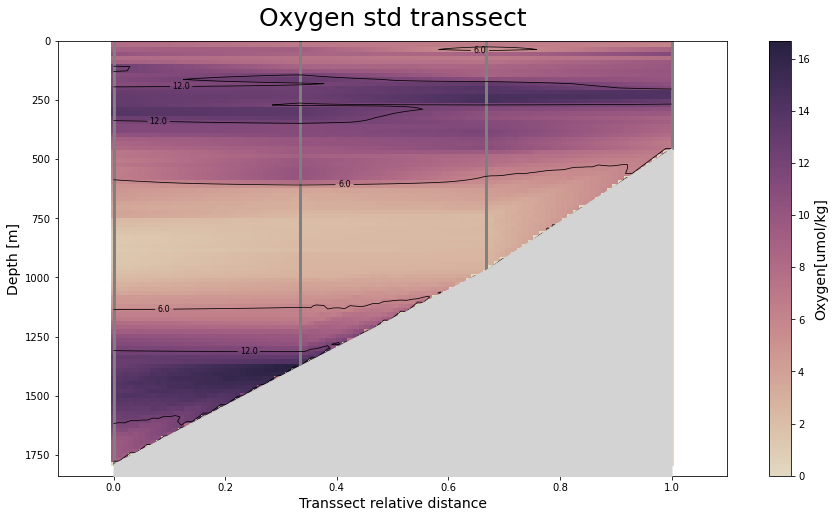

In [32]:
cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
#cmap = sns.color_palette("rocket_r", as_cmap=True)
#cmap = sns.cubehelix_palette(as_cmap=True)

interpolation='linear'

fig, ax1 = plt.subplots(1,1,figsize=(15,8))

#2nd plot
ax1.set_xlim(-0.1,1.1)
ax1.set_ylim(max(list_refdeps)+50,0)

#Creating the grid
points = list(zip(data_plot['std_profile']['x'], data_plot['std_profile']['depth']))
xi, yi = np.mgrid[0:1:100j, 0:max(list_refdeps):100j]
grid_ztest = griddata(points, np.nan_to_num(data_plot['std_profile'][variable]), (xi, yi), method=interpolation, rescale=True)
grid_ztest = np.nan_to_num(grid_ztest)

handle2 = ax1.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto')
b = ax1.scatter(data_plot['std_profile']['x'], data_plot['std_profile']['depth'], c='grey', s=2)

levels = 2
CS = ax1.contour(xi, yi, grid_ztest, levels=levels, colors=['k'], linewidths=0.75)
ax1.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=8)
cb = plt.colorbar(handle2, ax=ax1)
ax1.fill_between(dist,list_refdeps,max(list_refdeps)+100, color='lightgray', zorder=100)
ax1.margins(0.05)

cb.set_label(variable[0].upper()+variable[1:]+units[variable], fontsize = 14)
plt.ylabel('Depth [m]', fontsize = 14)
plt.xlabel('Transsect relative distance', fontsize = 14)
plt.title(variable[0].upper()+variable[1:]+' std transsect',fontsize=25, pad=15)

#plt.savefig(path+variable+'_std_transsect'+'_t'+str(min(transsects_selected))+'_to_t'+str(max(transsects_selected))+'.jpg', dpi=300)

plt.show()

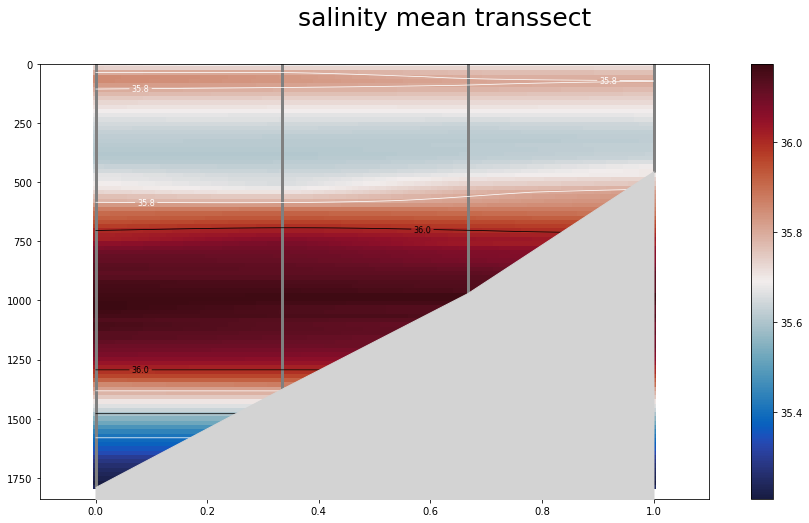

In [20]:
cmap = cmocean.cm.balance
interpolation = 'linear'

fig, ax1 = plt.subplots(1,1,figsize=(15,8))

#2nd plot
ax1.set_xlim(-0.1,1.1)
ax1.set_ylim(max(list_refdeps)+50,0)
interp = scipy.interpolate.Rbf(data_plot['mean_profile']['x'], data_plot['mean_profile']['depth'], data_plot['mean_profile'][variable], function=interpolation)
xi, yi = np.mgrid[0:1:100j, 0:max(list_refdeps):100j]
zi = interp(xi, yi)
handle2 = ax1.pcolormesh(xi, yi, zi, cmap=cmap, shading='auto')
b = ax1.scatter(data_plot['mean_profile']['x'], data_plot['mean_profile']['depth'], c='grey', s=2)
CS = ax1.contour(xi, yi, zi, levels=5,colors=['k','white'], linewidths=0.75)
ax1.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=8)
plt.colorbar(handle2, ax=ax1)
ax1.fill_between(dist,list_refdeps,max(list_refdeps)+100, color='lightgray', zorder=100)
ax1.margins(0.05)

plt.suptitle(variable+' mean transsect',fontsize=25)

#plt.savefig(path+variable+'_mean_transsect'+'_t'+str(min(transsects_selected))+'_to_t'+str(max(transsects_selected))+'.jpg')

plt.show()

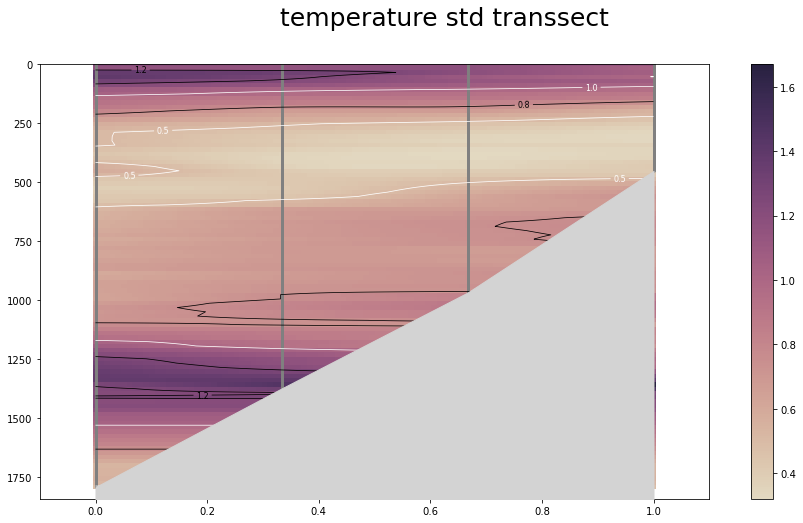

In [12]:
cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
#cmap = sns.color_palette("rocket_r", as_cmap=True)
#cmap = sns.cubehelix_palette(as_cmap=True)

interpolation='linear'

fig, ax1 = plt.subplots(1,1,figsize=(15,8))

#2nd plot
ax1.set_xlim(-0.1,1.1)
ax1.set_ylim(max(list_refdeps)+50,0)


interp = scipy.interpolate.Rbf(data_plot['std_profile']['x'], data_plot['std_profile']['depth'], data_plot['std_profile'][variable], function=interpolation)
xi, yi = np.mgrid[0:1:100j, 0:max(list_refdeps):100j]
zi = interp(xi, yi)
handle2 = ax1.pcolormesh(xi, yi, zi, cmap=cmap, shading='auto')
b = ax1.scatter(data_plot['std_profile']['x'], data_plot['std_profile']['depth'], c='grey', s=2)
CS = ax1.contour(xi, yi, zi, levels=5,colors=['k','white'], linewidths=0.75)
ax1.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=8)
plt.colorbar(handle2, ax=ax1)
ax1.fill_between(dist,list_refdeps,max(list_refdeps)+100, color='lightgray', zorder=100)
ax1.margins(0.05)

plt.suptitle(variable+' std transsect',fontsize=25)

#plt.savefig(path+variable+'_std_transsect'+'_t'+str(min(transsects_selected))+'_to_t'+str(max(transsects_selected))+'.jpg')

plt.show()

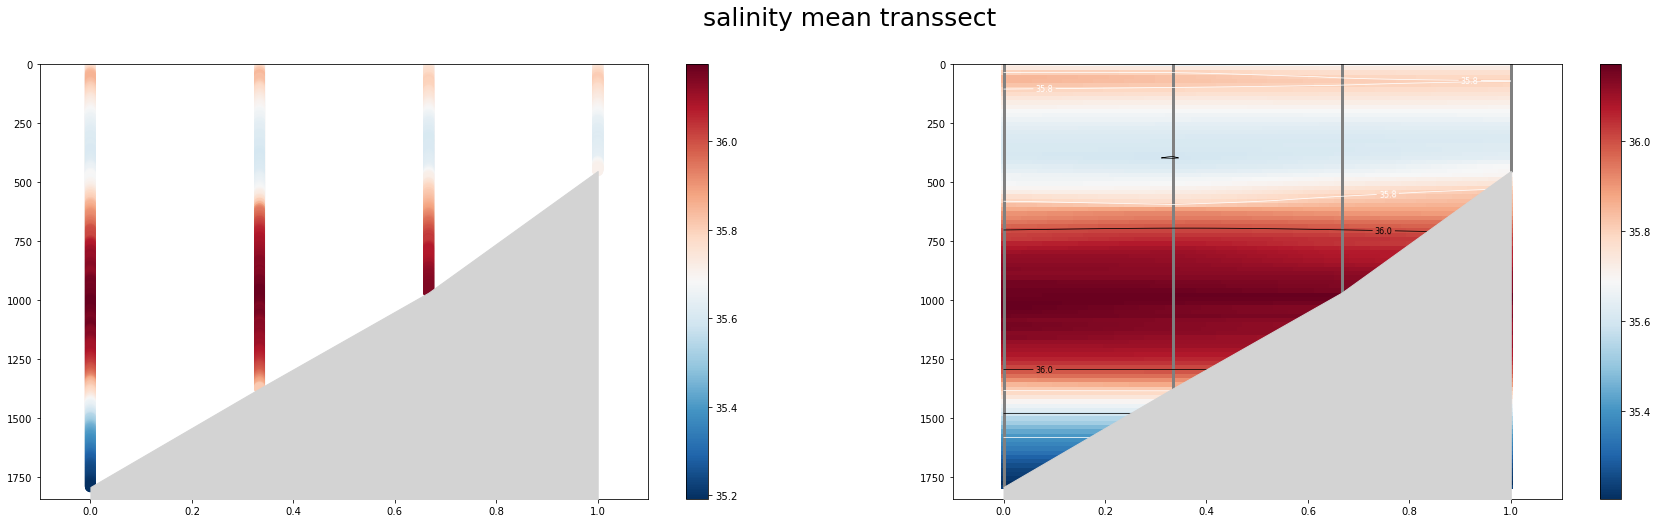

In [89]:
cmap='RdBu_r'
interpolation='linear'

fig, (ax0, ax1) = plt.subplots(1,2,figsize=(30,8))

#1st plot
ax0.set_xlim(-0.1,1.1)
ax0.set_ylim(max(list_refdeps)+50,0)
a = ax0.scatter(data_plot['mean_profile']['x'], data_plot['mean_profile']['depth'],
              c=data_plot['mean_profile'][variable],cmap=cmap, s=100)
plt.colorbar(a, ax=ax0)
ax0.fill_between(dist,list_refdeps,max(list_refdeps)+100, color='lightgray', zorder=100)

#2nd plot
ax1.set_xlim(-0.1,1.1)
ax1.set_ylim(max(list_refdeps)+50,0)
interp = scipy.interpolate.Rbf(data_plot['mean_profile']['x'], data_plot['mean_profile']['depth'], data_plot['mean_profile'][variable], function=interpolation)
xi, yi = np.mgrid[0:1:100j, 0:max(list_refdeps):100j]
zi = interp(xi, yi)
handle2 = ax1.pcolormesh(xi, yi, zi, cmap=cmap, shading='auto')
b = ax1.scatter(data_plot['mean_profile']['x'], data_plot['mean_profile']['depth'], c='grey', s=2)
CS = ax1.contour(xi, yi, zi, levels=5,colors=['k','white'], linewidths=0.75)
ax1.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=8)
plt.colorbar(handle2, ax=ax1)
ax1.fill_between(dist,list_refdeps,max(list_refdeps)+100, color='lightgray', zorder=100)
ax1.margins(0.05)

plt.suptitle(variable+' mean transsect',fontsize=25)

#plt.savefig(path+variable+'_mean_transsect'+'_t'+str(min(transsects_selected))+'_to_t'+str(max(transsects_selected)))

plt.show()

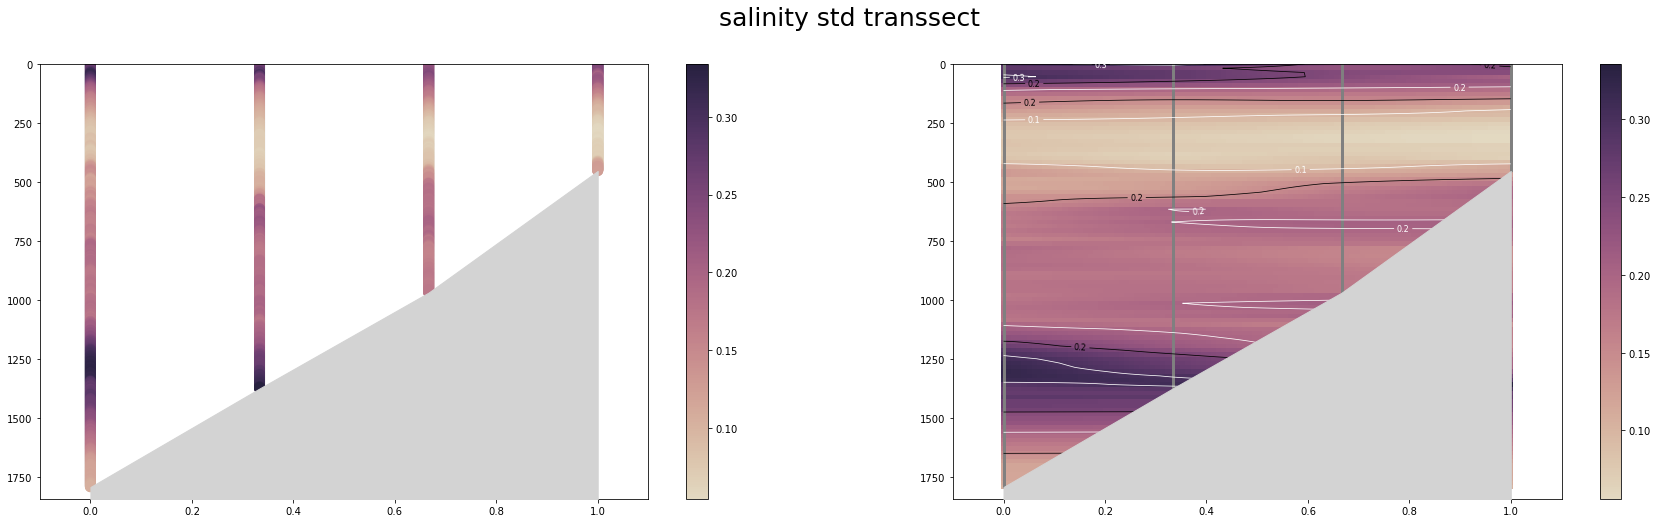

In [90]:
cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
#cmap = sns.color_palette("rocket_r", as_cmap=True)
#cmap = sns.cubehelix_palette(as_cmap=True)

interpolation='linear'

fig, (ax0, ax1) = plt.subplots(1,2,figsize=(30,8))

#1st plot
ax0.set_xlim(-0.1,1.1)
ax0.set_ylim(max(list_refdeps)+50,0)
a = ax0.scatter(data_plot['std_profile']['x'], data_plot['std_profile']['depth'],
              c=data_plot['std_profile'][variable],cmap=cmap, s=100)
plt.colorbar(a, ax=ax0)
ax0.fill_between(dist,list_refdeps,max(list_refdeps)+100, color='lightgray', zorder=100)

#2nd plot
ax1.set_xlim(-0.1,1.1)
ax1.set_ylim(max(list_refdeps)+50,0)
interp = scipy.interpolate.Rbf(data_plot['std_profile']['x'], data_plot['std_profile']['depth'], data_plot['std_profile'][variable], function=interpolation)
xi, yi = np.mgrid[0:1:100j, 0:max(list_refdeps):100j]
zi = interp(xi, yi)
handle2 = ax1.pcolormesh(xi, yi, zi, cmap=cmap, shading='auto')
b = ax1.scatter(data_plot['std_profile']['x'], data_plot['std_profile']['depth'], c='grey', s=2)
CS = ax1.contour(xi, yi, zi, levels=5,colors=['k','white'], linewidths=0.75)
ax1.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=8)
plt.colorbar(handle2, ax=ax1)
ax1.fill_between(dist,list_refdeps,max(list_refdeps)+100, color='lightgray', zorder=100)
ax1.margins(0.05)

plt.suptitle(variable+' std transsect',fontsize=25)

#plt.savefig(path+variable+'_std_transsect'+'_t'+str(min(transsects_selected))+'_to_t'+str(max(transsects_selected)))

plt.show()

In [26]:
list_stations_grouped = list(stations_grouped.values())
list_stations_grouped[0]

['19', '24', '26', '31', '38', '43']

In [79]:
list_stations_grouped = list(stations_grouped.values())
variable = 'salinity'

for a in range(len(stations_grouped)):
    group = list_stations_grouped[a]
    mean_profile = {}
    group_profile = []
    for ncast in group:
        var = data[ncast][variable].values
        group_profile.append(var)

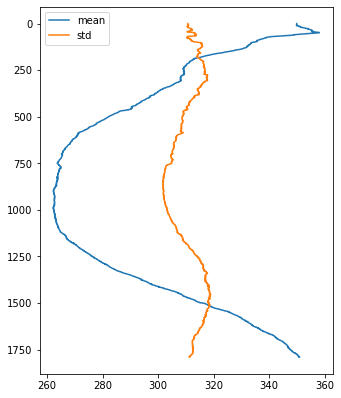

In [109]:
group = ['19', '24', '26', '31', '38', '43']
variable = 'oxygen'

group_var = []
for ncast in group:
    var = data[ncast][variable].values
    group_var.append(var)
group_var = np.array(group_var)

mean_profile = group_var.mean(axis=0)
std_profile = group_var.std(axis=0)

pd.Series(mean_profile).plot_cast(label = 'mean')
pd.Series(std_profile+300).plot_cast(label = 'std')
plt.legend()
plt.show()

In [113]:
variable = 'oxygen'

mean_profiles = {}
std_profiles = {}
for i in range(len(stations_grouped)):
    group = list(stations_grouped.values())[i]
    group_var = []
    for ncast in group:
        var = data[ncast][variable].values
        group_var.append(var)
    group_var = np.array(group_var)
    mean_profile = group_var.mean(axis=0)
    std_profile = group_var.std(axis=0)
    key = 'stations_'+str(i+1)
    mean_profiles[key] = mean_profile
    std_profiles[key] = std_profile

<AxesSubplot:>

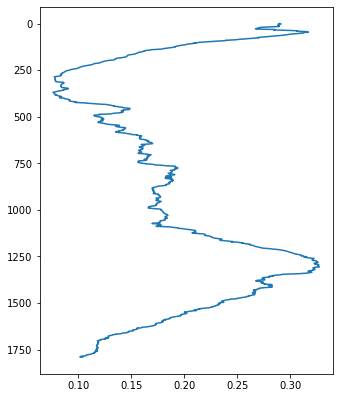

In [98]:
pd.Series(group_var.std(axis=0)).plot_cast()

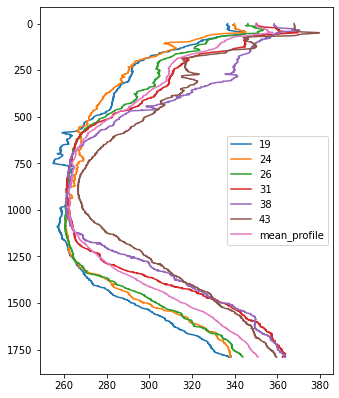

In [110]:
labels = []
for ncast in group:
    data[ncast][variable].plot_cast()
    labels.append(ncast)
pd.Series(mean_profile).plot_cast()
labels.append('mean_profile')
plt.legend(labels)
plt.show()

In [83]:
group

['16', '21', '29', '34', '35', '46']

In [74]:
group_var.sum(axis=0)

1791

<AxesSubplot:>

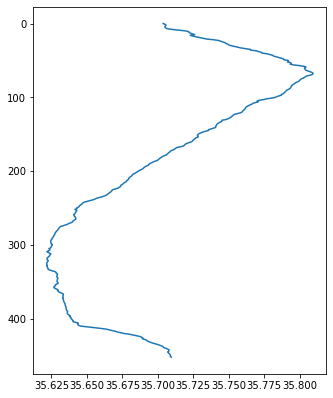

In [80]:
pd.Series(sum(group_profile)/len(group)).plot_cast()

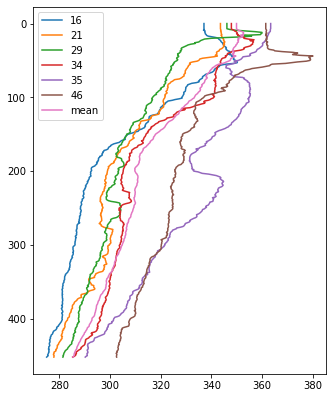

In [58]:
labels = []
for ncast in group:
    data[ncast][variable].plot_cast()
    labels.append(ncast)
pd.Series(sum(group_profile)/len(group)).plot_cast()
labels.append('mean')
plt.legend(labels)